# Notebook de preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import models, layers, initializers

In [2]:
FOLDER = "../data_MEX/train_set/"
FEATURES = ['dmop', 'saaf', 'ftl', 'evtf', 'ltdata']
N_VAL = 500
YEAR = 2012

In [3]:

## import de la première année d'une classe de variables quantitative (saaf, ltdata)
def import_quantitative_df(file_name, folder = FOLDER):
    query = f"{folder}*{file_name}*"
    file_name_list = glob.glob(query) 
    file_name_first = np.sort(file_name_list)[0]
    data = pd.read_csv(file_name_first, sep=",", index_col=0)
    print(file_name_first, "imported.")
    data['date'] = data.index
    data = data.reset_index(drop=True) 
    # for file_name in file_name_list_sorted:
    #     print(file_name)
    #     data = pd.read_csv(file_name, sep=",", index_col=0)
    #     saaf_data.append(data)
    # saaf = pd.concat(saaf_data)
    return data

def import_power_col(col = "NPWD2451", folder = FOLDER):
    query_power = f"{FOLDER}*power*"
    file_name_list = glob.glob(query_power) 
    file_name = np.sort(file_name_list)[0] # ordonne selon l'année
    data = pd.read_csv(file_name, sep=",", index_col=0, usecols = ["ut_ms", col])
    print(file_name, "imported.")
    data['date'] = data.index
    data = data.reset_index(drop=True)    
    return data

def import_ftl():
    file_name = "ftl"
    query = f"{FOLDER}*{file_name}*"
    file_name_list = glob.glob(query) 
    file_name_first = np.sort(file_name_list)[0]
    data = pd.read_csv(file_name_first, sep=",", index_col=0)
    print(file_name_first, "imported.")
    data = pd.get_dummies(data[["type", "flagcomms"]])
    data['date'] = data.index
    data = data.reset_index(drop=True)    
    data["flagcomms"] = data["flagcomms"].astype(int) # Passer les true/false en 1/0
    return data

# Copie des df puis concatenation 
# on trie par date -> ça intercale les mesures ltdata au milieu de celles de saaf
# on interpole tout ce qui manque (NaN) linéairement avec la méthode interpolate de pandas
# et PAF
def concatenate_and_interpolate_df(df_list):
    
    combined = pd.concat(df_list)
    combined = combined.sort_values("date").reset_index(drop=True)
    combined = combined.interpolate()
    combined["interval"] = pd.Series(combined["date"][1:].to_numpy() - combined["date"][:-1].to_numpy())
    print("Data interpolated :", len(combined), "rows.")
    return combined

def create_sampling_rate_vec(sec_interval, df):
    """
    Create a date (ut_ms format) vector piecewiese continuous during "sec_interval" seconds
    """
    timestep = sec_interval * 1000
    median_interval = df["interval"].median()
    nb_samples = len(df) 
    group_size = int(timestep // median_interval)
    nb_group = int(nb_samples // group_size)
    print(f"Sample groups : {nb_group}")
    vec = np.zeros(nb_samples)
    for i in range(nb_group):
        vec[group_size * i: group_size * (i + 1)] = [df["date"][i * group_size]] * group_size

    vec[group_size * nb_group :] = [df["date"][ nb_group * group_size]] * len(vec[group_size * nb_group : ])
    return vec

def subsample_df(df, sampling_rate_sec = 3600):
    """
    Subsample all columns of df with a sampling rate in seconds
    """
    group_vector = create_sampling_rate_vec(sampling_rate_sec, df)
    df["groups"] = group_vector
    df = df.groupby(by="groups").mean() ## place groups en index du df
    df = df.reset_index()
    df.drop(["interval", "groups"], inplace = True, axis = 1)
    print("Data subsampled")
    return df

In [4]:
saaf = import_quantitative_df("saaf")
ltdata = import_quantitative_df("ltdata")
ftl = import_ftl()
power = import_power_col()

## categorical

/home/yamsok/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


../data_MEX/train_set/context--2008-08-22_2010-07-10--saaf.csv imported.
../data_MEX/train_set/context--2008-08-22_2010-07-10--ltdata.csv imported.
../data_MEX/train_set/context--2008-08-22_2010-07-10--ftl.csv imported.
../data_MEX/train_set/power--2008-08-22_2010-07-10.csv imported.


In [5]:
data = concatenate_and_interpolate_df([saaf, ltdata, ftl, power])
data = subsample_df(data)

Data interpolated : 3111669 rows.
Sample groups : 16819
Data subsampled


In [36]:
data.drop(["date"], inplace = True, axis = 1)


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

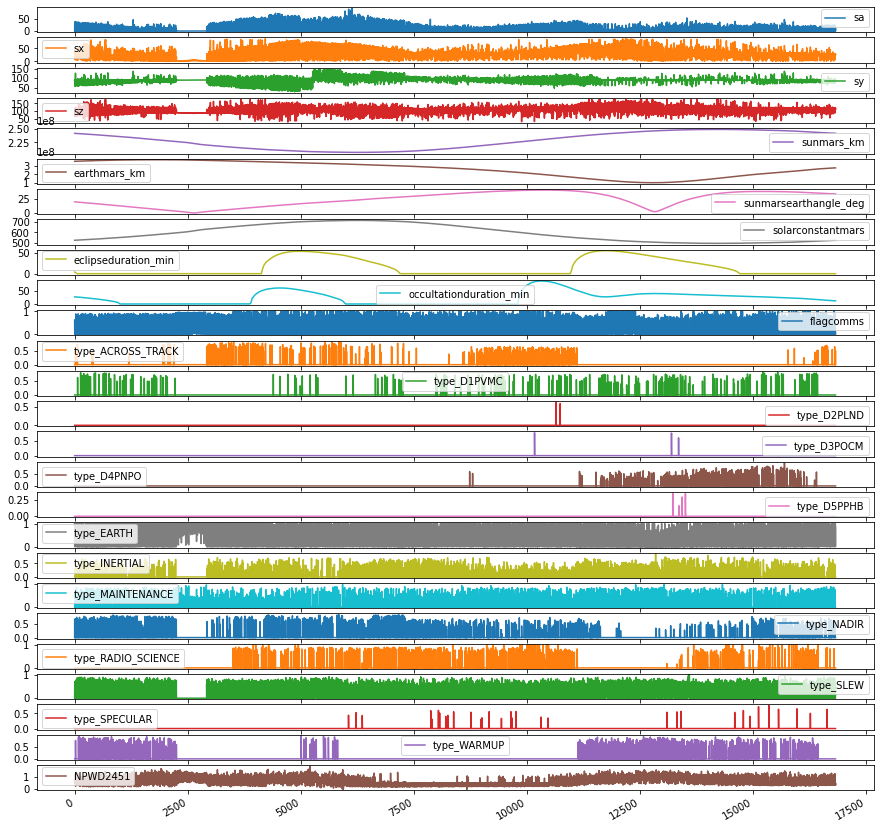

In [37]:
data.plot(subplots=True, figsize=(15,16))

In [7]:
X = data.copy()
X.drop(["NPWD2451"], inplace = True, axis = 1) # drop
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16820 entries, 0 to 16819
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sa                       16820 non-null  float64
 1   sx                       16820 non-null  float64
 2   sy                       16820 non-null  float64
 3   sz                       16820 non-null  float64
 4   date                     16820 non-null  float64
 5   sunmars_km               16820 non-null  float64
 6   earthmars_km             16820 non-null  float64
 7   sunmarsearthangle_deg    16820 non-null  float64
 8   solarconstantmars        16820 non-null  float64
 9   eclipseduration_min      16820 non-null  float64
 10  occultationduration_min  16820 non-null  float64
 11  flagcomms                16820 non-null  float64
 12  type_ACROSS_TRACK        16820 non-null  float64
 13  type_D1PVMC              16820 non-null  float64
 14  type_D2PLND           

In [8]:
y = data.copy()
y.drop(y.loc[:,"sa":"type_WARMUP"], inplace = True, axis = 1)
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16820 entries, 0 to 16819
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   NPWD2451  16820 non-null  float64
dtypes: float64(1)
memory usage: 131.5 KB


In [9]:
def scaling(x_train, x_test):
    scaler = StandardScaler() 
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    return x_train_scaled, x_test_scaled

In [10]:
train_len = int(len(X) * 0.8)
X_train, y_train = X[:train_len], y[:train_len]
X_test, y_test = X[train_len:], y[train_len:]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
# X_train_scaled, X_test_scaled = scaling(X_train, X_test)

In [72]:
X_train_scaled

array([[-0.48380989, -0.5974163 ,  0.04783792, ..., -1.03940993,
        -0.05089094, -0.29600081],
       [-0.15885334, -0.51443475,  0.07437665, ..., -0.4594684 ,
        -0.05089094, -0.29600081],
       [ 2.26131425,  0.83299217, -2.54582342, ...,  0.24133634,
        -0.05089094, -0.29600081],
       ...,
       [-0.34748435, -0.41445936, -0.17422797, ..., -0.74799025,
        -0.05089094, -0.29600081],
       [ 0.57143986, -0.02802577, -0.13564037, ..., -0.27775291,
        -0.05089094, -0.29600081],
       [ 0.6966149 ,  0.6363286 ,  0.01295161, ...,  0.86779672,
        -0.05089094, -0.29600081]])

In [73]:
y_train

,NPWD2451
0,0.700064
1,0.724025
2,1.187518
3,0.825453
4,0.882670
...,...
13451,1.000844
13452,0.778613
13453,0.566153
13454,0.885696


In [84]:
def build_model(n_layers, width):
    """
    Return a compiled keras ANN with n_layers layers and width neurons by layer
    """
    model = models.Sequential()
    # hidden layers
    for i in range(n_layers):
        model.add(layers.Dense(width))

#     output laye/rs
    model.add(layers.Dense(1, activation = "linear",
                           kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.02,seed=2020)))
    # Optimisation parameters
    metrics = ["mae"]
    model.compile(optimizer = 'adam', loss='mse', metrics = metrics)
    return model

def train_model(x_train_scaled, y_train, model) :
    """
    Run the training procedure and return the trained model, 
    """

    history = model.fit(x_train_scaled, 
                        y_train, 
                        epochs = 10,
                        validation_split=0.2, 
                        verbose = 2)
    return history, model

In [110]:
n_layers = 1
width = 1

    
model = build_model(n_layers, width)

history, trained_model = train_model(X_train_scaled, y_train["NPWD2451"].to_numpy(), model)


Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

337/337 - 0s - loss: 0.2522 - mae: 0.4095 - val_loss: 0.8343 - val_mae: 0.8542
Epoch 2/10
337/337 - 0s - loss: 0.0845 - mae: 0.2147 - val_loss: 0.6140 - val_mae: 0.6996
Epoch 3/10
337/337 - 0s - loss: 0.0647 - mae: 0.1895 - val_loss: 0.4642 - val_mae: 0.5866
Epoch 4/10
337/337 - 1s - loss: 0.0603 - mae: 0.1860 - val_loss: 0.3611 - val_mae: 0.5082
Epoch 5/10
337/337 - 0s - loss: 0.0581 - mae: 0.1841 - val_loss: 0.3113 - val_mae: 0.4652
Epoch 6/10
337/337 - 0s - loss: 0.0568 - mae: 0.1831 - val

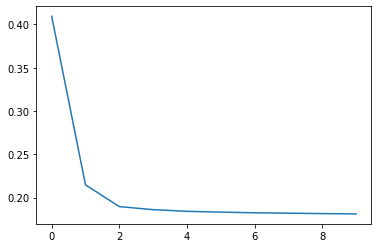

In [111]:
plt.plot(history.history['mae'])

In [112]:
pred = trained_model.predict(X_test_scaled)

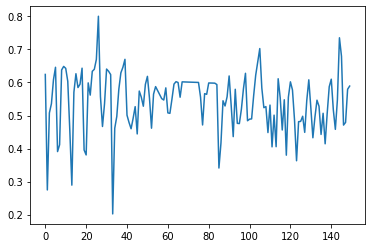

In [116]:
plt.plot(pred[50:200])

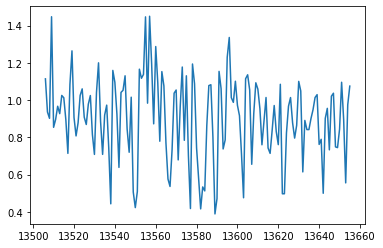

In [114]:
plt.plot(y_test[50:200])

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regr = RandomForestRegressor(20,max_depth=2, random_state=0)
regr.fit(X_train_scaled, y_train.values.ravel())

RandomForestRegressor(max_depth=2, n_estimators=20, random_state=0)

In [12]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [18]:
reg.score(X_test,y_test)

-2.925844011758694

<AxesSubplot:xlabel='NPWD2451'>

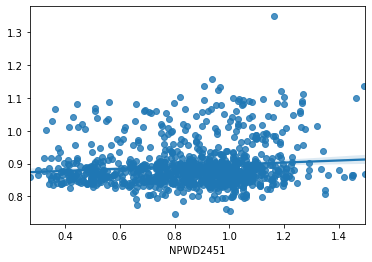

In [17]:
import seaborn as sns
predict = reg.predict(X_test)

sns.regplot(y_test[:1000],predict[:1000])


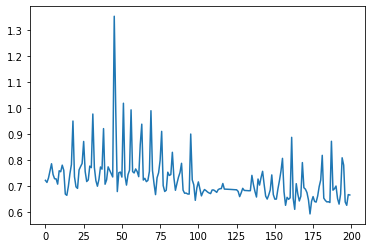

In [118]:
plt.plot(predict[:200])


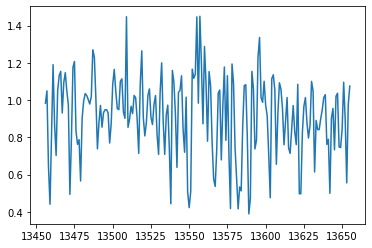

In [119]:
plt.plot(y_test[:200])


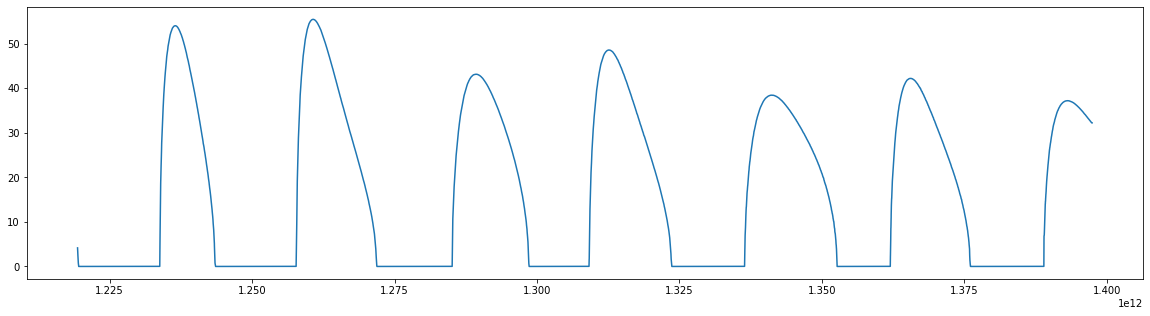

In [19]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(combined["date"], combined["eclipseduration_min"])
plt.show()

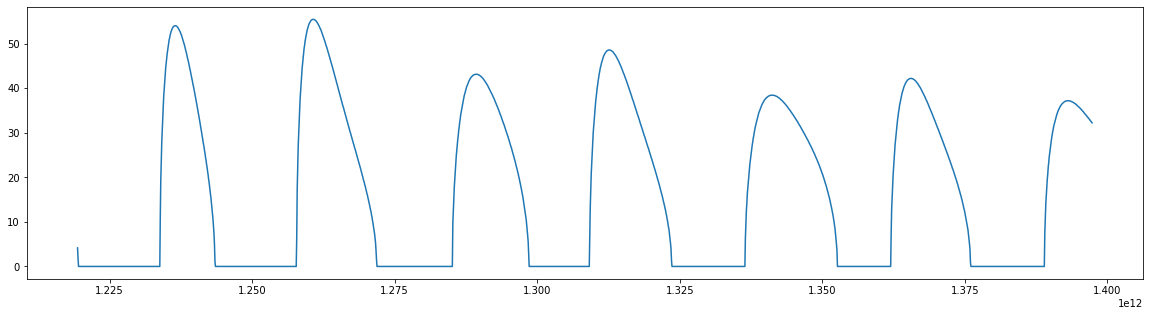

In [18]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(ltdata.index, ltdata["eclipseduration_min"])
plt.show()